# beomi/KcELECTRA-base

In [1]:
# Learning Device list Check 
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18339188205533308016
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2254123828
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10314148324994524109
physical_device_desc: "device: 0, name: GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [2]:
# %run KcELECTRA-base.version.py       # 필요한 라이브러리 설치
# !pip freeze                          # 설치된 라이브러리 확인

In [3]:
import re
import torch
import pandas as pd

# GPU 설정
# 없을 시 CPU
# CPU로 뜨지만, GPU 잘만 돌아감
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device:", device)

device: cpu


In [4]:
# 엑셀 파일에서 데이터프레임 읽기
df = pd.read_excel(r"C:\Users\GJAISCHOOL\Desktop\X_filter\Algorithm\dataset\sample_data(100).xlsx")

print(df.shape)
df.head()

(100, 2)


,Sentence,label
0,좌배 까는건 ㅇㅂ,1
1,집에 롱 패딩만 세 개다. 10년 더 입어야지 ㅋㅋ,0
2,개소리야 니가 빨갱이를 옹호하고 드루킹을 ㅇㅇ짓이라고 말못해서 삐진거야 빨갱아,1
3,세탁이라고 봐도 된다,0
4,애새끼가 초딩도 아니고 ㅋㅋㅋㅋ,1


In [5]:
null_idx = df[df.label.isnull()].index                             # 해당 index에 null 값 확인
df.loc[null_idx, "Sentence"]                                       # null 값이 존재한 인덱스의 Sentence 값 불러오기

# lable은 Sentence의 가장 끝 문장열로 설정
df.loc[null_idx, "label"] = df.loc[null_idx, "Sentence"].apply(lambda x: x[-1])

# Sentence는 "\t" 앞부분까지의 문자열로 설정
df.loc[null_idx, "Sentence"] = df.loc[null_idx, "Sentence"].apply(lambda x: x[-2])

In [6]:
train_data = df.sample(frac=0.8, random_state=42)                 # train(80%), test(20%) 셋 구분 
test_data = df.drop(train_data.index)                             # 랜덤으로 샘플링(랜덤으로 숫자 배치)

# 데이터셋 갯수 확인
print('중복 제거 전 학습 데이터셋 : {}'.format(len(train_data)))
print('중복 제거 전 테스트 데이터셋 : {}'.format(len(test_data)))

# 중복 데이터 제거
train_data.drop_duplicates(subset=["Sentence"], inplace=True)
test_data.drop_duplicates(subset=["Sentence"], inplace=True)

# 데이터셋 갯수 확인
print('중복 제거 후 학습 데이터셋 : {}'.format(len(train_data)))
print('중복 제거 후 테스트 데이터셋 : {}'.format(len(test_data)))

중복 제거 전 학습 데이터셋 : 80
중복 제거 전 테스트 데이터셋 : 20
중복 제거 후 학습 데이터셋 : 80
중복 제거 후 테스트 데이터셋 : 20


In [7]:
from transformers import ElectraTokenizer, ElectraForSequenceClassification, TFElectraForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

# KcELECTRA 모델 및 토크나이저 로드
Kc_model = "beomi/KcELECTRA-base"
Kc_tokenizer = AutoTokenizer.from_pretrained(Kc_model)

c:\Users\GJAISCHOOL\.conda\envs\nv38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
tokenized_train_sentences = Kc_tokenizer( 
    list(train_data["Sentence"]),           # train_data 리스트화
    return_tensors="pt",                    # pytorch의 tensor 형태로 변환
    max_length=128,                         # 최대 토큰길이 설정
    padding=True,                           # 학습 시 빈 값을 0으로 대체
    truncation=True,                        # 초과 토큰 제거
    add_special_tokens=True                 # 추가 토큰 설정
)

In [9]:
tokenized_test_sentences = Kc_tokenizer(
    list(test_data["Sentence"]),           # test_data 리스트화
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

In [10]:
"""
CLS(분류 토큰)   : 시작을 알릴 때 사용 \n
SEP(구분자 토큰) : 서로 다를 때 구분할 사용할 토큰 \n
MASK            : 특정 토큰이 마스크화, 모델이 예측하도록 훈련 \n
PAD             : 일관된 길이로 동일하게 만듦
                                                            """

'\nCLS(분류 토큰)   : 시작을 알릴 때 사용 \n\nSEP(구분자 토큰) : 서로 다를 때 구분할 사용할 토큰 \n\nMASK            : 특정 토큰이 마스크화, 모델이 예측하도록 훈련 \n\nPAD             : 일관된 길이로 동일하게 만듦\n                                                            '

In [11]:
print(tokenized_train_sentences[0])        # 0번째 문장에 해당하는 객체
print("="*200) 
print(tokenized_train_sentences[0].tokens) # 0번째 문장에 토큰의 목록
print("="*200)
print(tokenized_train_sentences[0].ids)    # 0번째 문장에 대한 고유 ID

Encoding(num_tokens=94, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['ĠìĥĪë¡ľ', 'ìĺ¤ë©´', 'Ġëĭ¤', 'Ġê·¸ëłĩê²Į', 'íķ¨', 'ĠìĹ´ìĭ¬íŀĪ', 'ĠíķĺëĬĶ', 'íĭ°', 'ë¥¼', 'ĠíĮįíĮį', 'ëĤ´ê³ł', 'ĠëŃĲ', 'Ġë°Ķê¾¸ê³ł', 'ĠëŃĲ', 'íķĺê¸°ë¡ľ', 'ĠíķĺìŀĲ', 'Ġìķķë°ķ', 'ìĿĦ', 'Ġì£¼', 'ìŀĸëĥĲ', 'Ġ10', 'ëħĦê°Ħ', 'ĠëĦĪë¬´', 'ĠíĥĢ', 'ìĦ±ìĹĲ', 'Ġìłĸ', 'ìĸ´', 'ìĤ´', 'ìķĺëįĺ', 'ê±°', 'ĠìķĦëĭĪëĥĲ', '?', 'ĠìľĦê¸°', 'ê°Ĳ', 'ìĹĨìĿ´', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[3718, 4283, 374,

In [12]:
class CurseDataset(torch.utils.data.Dataset):                                        # 학습을 위한 데이터셋 만들기     
    def __init__(self, encoding, labels):                                            # pytorch에서 학습할 수 있게 데이터셋 생성
        self.encodings = encoding                                                    # Feature Data / 'Sentence'
        self.labels = labels                                                         # Target Data / 'Label'
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} # self.encodings 딕셔너리 내의 값 중에 val를 torch.tensor로 변환해 하여
        item["labels"] = torch.tensor(self.labels[idx])                             # key: toch.tensor(val[ix])라는 item 딕셔너리 형성
        return item                                                                 # 새로운 labels 키 값에 value torch.tensor(self.labels[idx]) 쌍을 생성
    
    def __len__(self):
        return len(self.labels)                                                     # self.labels 길이 반환

In [13]:
# train_set, test_set에 대한 데이터셋을 각각 생성
train_label = train_data["label"].values
test_label = test_data["label"].values

train_dataset = CurseDataset(tokenized_train_sentences, train_label)
test_dataset = CurseDataset(tokenized_test_sentences, test_label)

In [14]:
Kc_model = AutoModelForSequenceClassification.from_pretrained(Kc_model, num_labels=2)   # 사전 학습된 모델 찾아오기
Kc_model.to(device)                                                                       # num_labels 평가지표 확인

Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.out_proj.weight', 'classifi

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=3)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [15]:
# 3 - 2 학습 파라미터 설정
training_args = TrainingArguments(
    output_dir = './results',           # 학습결과 저장경로
    num_train_epochs=10,                # 학습 epoch 설정
    per_device_train_batch_size = 8,    # train batch_size 설정
    per_device_eval_batch_size = 64,    # test batch_size 설정
    logging_dir = './logs',             # 학습 log 저장경로 / 손실 값 저장
    logging_steps=500,                  # 학습 log 기록 단위 / 500번 마다 출력
    save_total_limit = 2,               # 학습결과 저장 최대갯수
)

In [16]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# 학습과정에서 사용할 평가지표를 위한 함수 설정
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # 정밀도, 재현율, f1 구하기 
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
  # 정확도 구하기
  acc = accuracy_score(labels, preds)
  return{
      'accuracy': acc,
      'f1': f1,
      'precision': precision,
      'recall': recall
  }

In [17]:
# Trainer 모듈을 사용해 모델의 학습을 컨트롤하은 trainer를 생성
trainer = Trainer(
    model = Kc_model,                    # 학습하고자하는 Transformers model
    args=training_args,                  # 위에서 정의한 학습 피라미터 설정
    train_dataset=train_dataset,         # 학습 데이터셋
    eval_dataset=test_dataset,           # 평가 데이터셋
    compute_metrics=compute_metrics,     # 평가지표
)

In [18]:
trainer.train()

c:\Users\GJAISCHOOL\.conda\envs\nv38\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\GJAISCHOOL\AppData\Local\Temp\ipykernel_20024\1869798269.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} # self.encodings 딕셔너리 내의 값 중에 val를 torch.tensor로 변환해 하여
100%|██████████| 100/100 [04:41<00:00,  2.81s/it]

{'train_runtime': 281.1661, 'train_samples_per_second': 2.845, 'train_steps_per_second': 0.356, 'train_loss': 0.29647657394409177, 'epoch': 10.0}


TrainOutput(global_step=100, training_loss=0.29647657394409177, metrics={'train_runtime': 281.1661, 'train_samples_per_second': 2.845, 'train_steps_per_second': 0.356, 'train_loss': 0.29647657394409177, 'epoch': 10.0})

C:\Users\GJAISCHOOL\AppData\Local\Temp\ipykernel_20024\1869798269.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} # self.encodings 딕셔너리 내의 값 중에 val를 torch.tensor로 변환해 하여
100%|██████████| 1/1 [00:00<00:00, 166.53it/s]


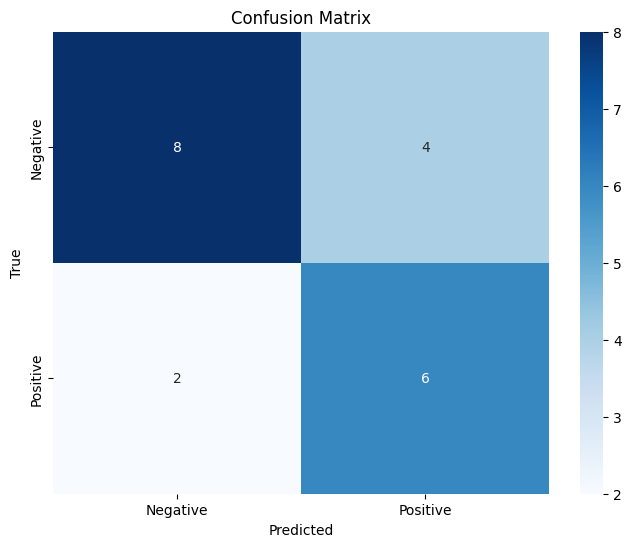

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Evaluate on the test dataset
results = trainer.predict(test_dataset)

# Get the true labels and predicted logits
true_labels = test_dataset.labels
predicted_logits = results.predictions
predicted_labels = np.argmax(predicted_logits, axis=1)

# Calculate the confusion matrix
conf_mat = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [66]:
def sentence_predict(sent):
    # 평가모드로 변경
    Kc_model.eval()

    # 입력된 문장 토크나이징
    tokenized_sent = Kc_tokenizer(
        sent,
        return_tensors="pt",
        truncation=True,
        add_special_tokens=True,
        max_length=128
    )

    # 모델이 위치한 GPU로 이동
    # tokenized_sent.to(deivce)

    # 예측
    with torch.no_grad():
        outputs = Kc_model(
            input_ids=tokenized_sent["input_ids"],
            attention_mask=tokenized_sent["attention_mask"],
            token_type_ids=tokenized_sent["token_type_ids"]
        )

    # 결과 return
    logits = outputs[0]
    logits = logits.detach().cpu()
    result = logits.argmax(-1)
    sentence = True
    input_sentence = tokenized_sent["input_ids"]
    if result == 0:
        sentence = True

    elif result == 1:
        sentence = False
    return sentence, input_sentence


sentence_predict("씨발")[0]

True

In [21]:
# 'RNN_2' 모듈을 가져오기 위한 경로를 sys.path에 추가
import sys
sys.path.append(r'C:\Users\GJAISCHOOL\Desktop\X_filter\Algorithm\RNN')
 
# 'RNN' 모듈을 import
from RNN import *


Name: tensorflow
Version: 2.9.3
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\gjaischool\.conda\envs\nv38\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: pykospacing

Epoch 1/200
1214/1214 - 24s - loss: 4.2195 - accuracy: 0.2174 - 24s/epoch - 20ms/step
Epoch 2/200
1214/1214 - 23s - loss: 3.1312 - accuracy: 0.4086 - 23s/epoch - 19ms/step
Epoch 3/200
1214/1214 - 21s - loss: 2.6786 - accuracy: 0.4783 - 21s/epoch - 17ms/step
Epoch 4/200
1214/1214 - 21s - loss: 2.5141 - accuracy: 0.4989 - 21s/epoch - 18ms/step
Epoch 5/200
1214/1214 - 26s - loss: 2.4428 - accuracy: 0.5059 

In [40]:
def badword_find(sent):
    badword_df = pd.read_excel(r'C:\Users\GJAISCHOOL\Desktop\X_filter\Algorithm\dataset\word_list.xlsx')
    found_bad_word = False  # 입력 문장에 단어가 발견되었는지를 나타내는 플래그
    for idx, row in badword_df.iterrows():
        if row["WORD"] in sent:
            # 'WORD'가 입력 문장에 포함된 경우
            new_word = row["대체어"]
            if not pd.isnull(new_word):
                RNN_result = sentence_generation(new_word, 2) + " "
                sent = sent.replace(row["WORD"], RNN_result)
                found_bad_word = True
            else:
                sent = sent.replace(row["WORD"], "*" * len(row["WORD"]))
                found_bad_word = True
    
    if not found_bad_word:
        # result = "@" * len(input_sentence)
        sent = "혐오 표현입니다."
    return sent

# 테스트
input_sentence = "엄마가 죽었으면 좋겠어"
speak_result = badword_find(input_sentence)
print(speak_result)

혐오 표현입니다.


In [53]:
def speak_pre(sent):
    sentence = sentence_predict(sent)
    if sentence[0] == True:
        return sent
    elif sentence[0] == False:
        return badword_find(sent)
    
def speak(sent):
    speak_pre(sent)
    sentence = sentence_predict(sent)
    if sentence == True:
        return sent
    elif sent == "혐오 표현입니다.":
        return sent
    elif sentence == False:
        return badword_find(sent)

In [54]:
import re
import kss
from pykospacing import Spacing
from soynlp.normalizer import repeat_normalize

# 띄어쓰기 설정
spacing = Spacing()

In [55]:
# 특수문자 제거
def cleanse(text):
    pattern = re.compile(r'\s+')
    text = re.sub(pattern, ' ', text)
    text = re.sub('[^가-힣ㄱ-ㅎㅏ|a-zA-Z0-9]','', text)
    return text

In [56]:
def clean_and_repeat_normalize(text):
    cleansed_text = cleanse(text)                                             # 특수문자 제거
    normalized_text = repeat_normalize(cleansed_text, num_repeats=2)          # 중복문자 제거
    input_data = re.sub(r'\d', '', normalized_text)                           # 제거
    normalized_text = spacing(input_data)                                     # 띄어쓰기 보정 

    return normalized_text

clean_and_repeat_normalize("아버지가방에들어가신다")

'아버지가 방에 들어가신다'

In [57]:
def final_output():
    input_text = clean_and_repeat_normalize(input())
    sentences = kss.split_sentences(input_text)

    sentences_list = []
    for sentence in sentences:
        speak(sentence)
        sentences_list.append(sentence) 

    long_test = ' '.join(sentences_list)
    print(long_test)
    return long_test

In [58]:
# 씨1@발 이게 맞아?
final_output()

씨발


'씨발'